### 用 if else 的方式找出大的那個 beam 當作卷積的 beam
做 HCN/CO 的 ratio map

最初代中，好一點的版本

檔案如下：
1. HCN(1-0)_mom0_reproj.fits
2. CO(1-0) mom0_convole.fits
3. HCN-CO_ratio.fits


In [6]:
from astropy.io import fits
import matplotlib.pyplot as plt

from astropy.wcs import WCS
from reproject import reproject_interp

from radio_beam import Beam, Beams # 靠北這兩個不一樣喔
from astropy.convolution import convolve_fft
from astropy import units # arc之類的單位會用到

import numpy as np

In [ ]:
# import data (moment0.fit of CO&&HCN)
CO_hdul = fits.open("'/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvpData/HCN-CO/CO(1-0)_mom0.fits'")
HCN_hdul = fits.open("/Users/aqing/Documents/1004/Circinus_galaxy/Ratio-Map/mvpData/HCN-CO/HCN(1-0)_mom0.fits")

CO_header = CO_hdul[0].header
HCN_header = HCN_hdul[0].header
CO_ima = CO_hdul[0].data.squeeze()
HCN_ima = HCN_hdul[0].data.squeeze()

In [8]:
# reprojection&&resampling
CO_wcs = WCS(CO_header, naxis=2)
HCN_wcs = WCS(HCN_header, naxis=2)
CO_shape = CO_ima.shape
HCN_ima_reproj, footprint = reproject_interp((HCN_ima, HCN_wcs), CO_wcs, shape_out=CO_shape)

'''
#%matplotlib widget 
# only use that upper line in browser
plt.figure(1) # 幹我就不會用 subplots()
plt.subplot(projection=CO_wcs)
plt.imshow(CO_ima, cmap='jet', vmin=0) # vmin/vmax 算是一種 bias嗎 #inferno
plt.colorbar()
plt.title("CO(1-0) mom0")
plt.figure(2)
plt.subplot(projection=CO_wcs)
plt.imshow(HCN_ima_reproj, cmap='jet', vmin=0)
plt.colorbar()
plt.title("HCN(1-0) mom0_reprojecteed")
'''
'''
plt.figure(3)
plt.subplot(projection=HCN_wcs)
plt.imshow(HCN_ima)
'''
#plt.show()

'\nplt.figure(3)\nplt.subplot(projection=HCN_wcs)\nplt.imshow(HCN_ima)\n'

In [9]:
# save the reproj(HCN) as a new FITS
# 經過了測試。。。十分成功
HCN_header_reproj = CO_header.copy()
HCN_header_reproj['BMIN'] = HCN_header['BMIN'] # 但是有關於 beam width 的東西要從原始的 HCN header 中更新
HCN_header_reproj['BMAJ'] = HCN_header['BMAJ']
HCN_header_reproj['BPA'] = HCN_header['BPA']
HCN_header_reproj['HISTORY'] = 'reproject WCS to CO_wcs, CO(1-0)_mom0_2.fits'

HCN_hdu_reproj = fits.PrimaryHDU(data=HCN_ima_reproj, header=HCN_header_reproj)
HCN_hdul_reproj = fits.HDUList([HCN_hdu_reproj])
HCN_hdul_reproj.writeto('HCN(1-0)_mom0_reproj.fits', overwrite=True)
print('Successfully saved the reprojected data of HCN to "HCN(1-0)_mom0_reproj.fits"')
print()
# close all HDUList
CO_hdul.close()
HCN_hdul.close()
HCN_hdul_reproj.close()
print('All HDUlists were closed')

Successfully saved the reprojected data of HCN to "HCN(1-0)_mom0_reproj.fits"

All HDUlists were closed


In [10]:
# find the beam to convolve
# just pick the Larger beam
CO_beam = Beam.from_fits_header(CO_header)
HCN_beam_reproj = Beam.from_fits_header(HCN_header_reproj)

pixelScale = 0.5*units.arcsec ##

'''
0.005 : 大哥補藥亂設啊，一坨
0.22 : CDELT
0.5 : kernel size = 55 * 55
'''
#pixelScale = CO_header['CDELT1']*units.arcsec # 痾痾那個單位轉換to的忘記怎麼寫了

if CO_beam.major >= HCN_beam_reproj.major: # can't use index on Beam object
    tarBeam = CO_beam
    kernel = tarBeam.deconvolve(HCN_beam_reproj).as_kernel(pixscale=pixelScale) # make the kenel
    CO_ima_final = CO_ima.copy()
    HCN_ima_final = convolve_fft(HCN_ima_reproj, kernel) # ima_convolve
else:
    tarBeam = HCN_beam_reproj
    kernel = tarBeam.deconvolve(CO_beam).as_kernel(pixscale=pixelScale) # make the kenel
    CO_ima_final = convolve_fft(CO_ima, kernel) # ima_convolve
    HCN_ima_final = HCN_ima_reproj.copy()

print("THE", tarBeam)
print(f"kernel shape: {kernel.shape}")
print(f"image shape: {CO_shape}")
print('** if ur kernel is so much bigger than image, you will get 一坨 :-(')
print()
print('Successfully convolved the image !ouo(((')

THE Beam: BMAJ=4.4068285951056 arcsec BMIN=3.53323497694104 arcsec BPA=40.60257850668 deg
kernel shape: (55, 55)
image shape: (480, 480)
** if ur kernel is so much bigger than image, you will get 一坨 :-(

Successfully convolved the image !ouo(((


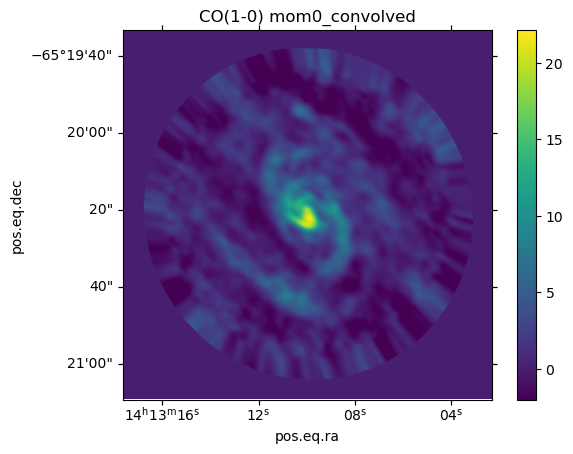

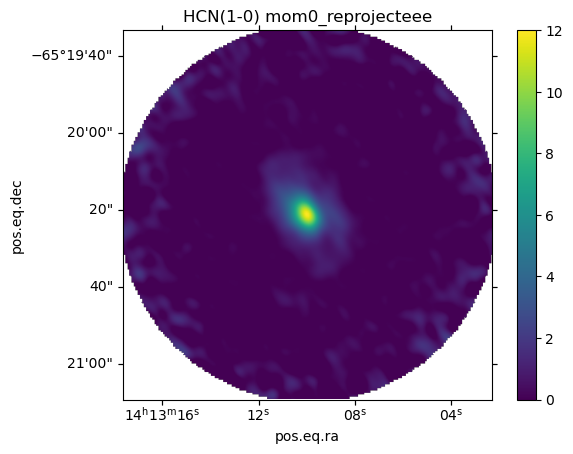

In [11]:
# show the convoled imaa
plt.figure()
plt.subplot(projection=CO_wcs)
plt.imshow(CO_ima_final, vmin=-2)
plt.title("CO(1-0) mom0_convolved")
plt.colorbar()

c_header = CO_header.copy() # 大家的座標都投在CO
c_header['BMAJ'] = tarBeam.major.to(units.deg).value
c_header['BMIN'] = tarBeam.minor.to(units.deg).value
c_header['BPA'] = tarBeam.pa.to(units.deg).value
fits.writeto('CO(1-0) mom0_convole.fits', CO_ima_final, c_header, overwrite=True)

plt.figure()
plt.subplot(projection=CO_wcs)
plt.imshow(HCN_ima_final, vmin=0)
plt.title("HCN(1-0) mom0_reprojecteee")
plt.colorbar()

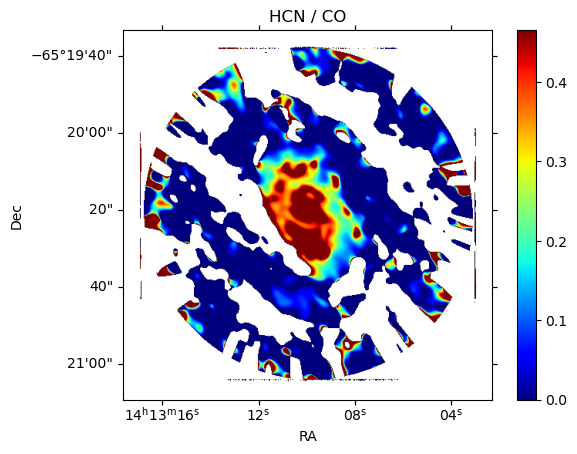

In [12]:
# ratio arrrrr
#%matplotlib widget # use brower to apply this function
with np.errstate(divide='ignore', invalid='ignore'): # 先不要報錯
    ratioMap = np.where(CO_ima_final>2*10**(-3), HCN_ima_final/CO_ima_final, np.nan)
    #ratioMap = np.where(CO_ima_final!=0, HCN_ima_final/CO_ima_final, np.nan)
    #ratioMap = np.where(ratioMap>1, np.nan, ratioMap) # 欸好像有用ㄟ？ 直接砍掉 >1 的值

plt.figure(4)
plt.subplot(projection=CO_wcs)
plt.imshow(ratioMap, origin='lower', cmap='jet', vmin=0, vmax=np.nanpercentile(ratioMap, 90))
#plt.imshow(ratioMap, cmap='jet') #inferno
#plt.imshow(ratioMap, origin='lower', cmap='jet', vmin=0, vmax=0.28)
plt.title("HCN / CO")
plt.colorbar()
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

In [13]:
# save the ratio map as new fits
ratioMap_header = CO_header.copy() # 大家的座標都投在CO
ratioMap_header['BMAJ'] = tarBeam.major.to(units.deg).value
ratioMap_header['BMIN'] = tarBeam.minor.to(units.deg).value
ratioMap_header['BPA'] = tarBeam.pa.to(units.deg).value
ratioMap_header['BTYPE'] = 'Ratio Map'
ratioMap_header['BUNIT'] = 'Ratio' # ?? 這可以這樣寫喔
ratioMap_header['HISTORY'] = 'HCN/CO ratio map, by astropy'
print(CO_beam)
print(HCN_beam_reproj)
print(tarBeam)
print()
fits.writeto('HCN-CO_ratio.fits', ratioMap, ratioMap_header, overwrite=True) # 喔喔可以寫成一行
print('Successfully saved the ratio map of HCN&&CO to "HCN-CO_ratio.fits"')

Beam: BMAJ=1.6457359820634 arcsec BMIN=1.01729727165636 arcsec BPA=73.02849492285 deg
Beam: BMAJ=4.4068285951056 arcsec BMIN=3.53323497694104 arcsec BPA=40.60257850668 deg
Beam: BMAJ=4.4068285951056 arcsec BMIN=3.53323497694104 arcsec BPA=40.60257850668 deg

Successfully saved the ratio map of HCN&&CO to "HCN-CO_ratio.fits"
